In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.model_selection import train_test_split

# 对原始数据进行处理增加小时列, 之后都读取 'data/first_season.xlsx' 文件即可
df = pd.read_excel('data/第四季度.xlsx')
hours = []
for i in df['时间']:
    hours.append(i.hour+1)
df.insert(1,'小时',hours)
df.to_excel('data/fourth_season.xlsx',index=None)

'''
使用SVR模型进行预测时，我们采用的是过去的24h的数据作为特征，下一个小时的数据作为标签
例如9月1日1时-9月1日24时为特征，9月2日1时为标签
   9月1日2时-9月2日1时为特征，9月2日2时为标签
   依次类推，可以将原始数据中的1776条，转换成为1752个样本，每个样本的前24列为特征，最后一列为标签  
'''

def train_test(dataset):
    DELAY = 7  # 选择过去7h数据作为特征（可以自行设置其他值）
    data = dataset.iloc[0:-1, 3].values
    new_data = np.zeros((len(data) - DELAY, DELAY + 1))
    for i in range(len(data) - DELAY):
        new_data[i, 0:DELAY] = data[i:i + DELAY]
        new_data[i, DELAY] = data[i + DELAY]

    # 确保数据均为 float型
    new_data = new_data.astype('float32')
    # 将特征归一化
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(new_data)
    X, y = scaled[:, 0:DELAY], scaled[:, DELAY]


    # 划分训练集和测试集
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=1, shuffle=False)
    return train_X, train_y, test_X, test_y, scaler


def train_svr_GridSearch():
    param_grid = {"C": [0.001,0.005,0.01,0.05,0.1,0.5,1,5,10],
                  'gamma': [0.001,0.005,0.01,0.05,0.1,0.5,1,5,10]}

    model = SVR(epsilon=0.1, kernel='rbf')
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                         scoring="neg_mean_squared_error", verbose=1)
    grid_search.fit(X_train, y_train)
    
    print('网格搜索最好的参数为:')
    print(grid_search.best_params_)
    best_model = grid_search.best_estimator_

    # 预测
    predicted_train = best_model.predict(X_train)
    predicted_test = best_model.predict(X_test)

    # 对预测值进行反归一化
    predicted_train = scaler.inverse_transform(np.concatenate((X_train, predicted_train.reshape(-1, 1)), axis=1))
    predicted_test = scaler.inverse_transform(np.concatenate((X_test, predicted_test.reshape(-1, 1)), axis=1))
    predicted_train = predicted_train[:, -1]
    predicted_test = predicted_test[:, -1]

    # 对真实值值进行反归一化
    train = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
    test = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)
    real_train = scaler.inverse_transform(train)[:, -1]
    real_test = scaler.inverse_transform(test)[:, -1]

    # 训练集误差
    RMSE_train = np.sqrt(mse(real_train, predicted_train))
    MAPE_train = mape(real_train, predicted_train)

    # 测试集误差
    RMSE_test = np.sqrt(mse(real_test, predicted_test))
    MAPE_test = mape(real_test, predicted_test)
    return RMSE_train, MAPE_train, RMSE_test, MAPE_test, predicted_test


def Train_SVR():
    model = SVR()
    model.fit(X_train, y_train)
    # 预测
    predicted_train = model.predict(X_train)
    predicted_test = model.predict(X_test)

    # 对预测值值进行反归一化
    predicted_train = scaler.inverse_transform(np.concatenate((X_train, predicted_train.reshape(-1, 1)), axis=1))
    predicted_test = scaler.inverse_transform(np.concatenate((X_test, predicted_test.reshape(-1, 1)), axis=1))
    predicted_train = predicted_train[:, -1]
    predicted_test = predicted_test[:, -1]

    # 对真实值值进行反归一化
    train = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
    test = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)
    real_train = scaler.inverse_transform(train)[:, -1]
    real_test = scaler.inverse_transform(test)[:, -1]


    test_y_real_df = pd.DataFrame(data=real_test)
    test_y_real_df.to_excel('./data/test_y_real_df.xlsx')


    # 计算平均百分比误差MAPE和均方根误差RMSE
    # 训练集误差
    RMSE_train = np.sqrt(mse(real_train, predicted_train))
    MAPE_train = mape(real_train, predicted_train)
    
    # 测试集误差
    RMSE_test = np.sqrt(mse(real_test, predicted_test))
    MAPE_test = mape(real_test, predicted_test)

    test_y_pred_df = pd.DataFrame(data=real_test)
    test_y_pred_df.to_excel('./data/svr_test_y_pred.xlsx')
    return RMSE_train, MAPE_train,predicted_test, RMSE_test, MAPE_test


def Predict_SVR(datatype='test'):
    # 预测
    if datatype == 'test':
        predicted_test = model.predict(X_test)
        # 对预测值值进行反归一化
        predicted_test = scaler.inverse_transform(np.concatenate((X_test, predicted_test.reshape(-1, 1)), axis=1))
        predicted_test = predicted_test[:, -1]

        test = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)
        real_test = scaler.inverse_transform(test)[:, -1]
        return real_test, predicted_test
    # 对真实值值进行反归一化
    if datatype == 'train':
        predicted_train = model.predict(X_train)
        predicted_train = scaler.inverse_transform(np.concatenate((X_train, predicted_train.reshape(-1, 1)), axis=1))
        predicted_train = predicted_train[:, -1]
        train = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        real_train = scaler.inverse_transform(train)[:, -1]
        return real_train, predicted_train


if __name__ == '__main__':
    # train_svr_GridSearch(df)
    X_train, y_train, X_test, y_test, scaler = train_test(dataset=df)
    train_RMSE, train_MAPE, pred_test, test_RMSE, test_MAPE = Train_SVR()
    pd.DataFrame(pred_test).to_excel('./data/svr.xlsx',index=None)
    print(f'没有采用网格搜索优化, svr的表现结果是:')
    print('train_RMSE:%.4f'%(train_RMSE))
    print('train_MAPE:%.4f'%(train_MAPE))
    print('test_RMSE:%.4f'%(test_RMSE))
    print('test_MAPE:%.4f'%(test_MAPE))
    
    print('-'*50)
    print('采用网格搜索寻找最优参数')
    RMSE_train, MAPE_train, RMSE_test, MAPE_test, pred_test = train_svr_GridSearch()
    pd.DataFrame(pred_test).to_excel('./data/svr_GS.xlsx',index=None)
    print('train_RMSE:%.4f'%(RMSE_train))
    print('train_MAPE:%.4f'%(MAPE_train))
    print('test_RMSE:%.4f'%(RMSE_test))
    print('test_MAPE:%.4f'%(MAPE_test))

没有采用网格搜索优化, svr的表现结果是:
train_RMSE:1303.8005
train_MAPE:0.0449
test_RMSE:1172.5172
test_MAPE:0.0440
--------------------------------------------------
采用网格搜索寻找最优参数
Fitting 5 folds for each of 81 candidates, totalling 405 fits
网格搜索最好的参数为:
{'C': 10, 'gamma': 0.1}
train_RMSE:1182.1286
train_MAPE:0.0384
test_RMSE:1000.9990
test_MAPE:0.0356


### 利用eemd分解

In [7]:
import copy

df = pd.read_excel('data/fourth_season.xlsx')
imf = np.load('data/eemd.npy')
TEST_SIZE = len(y_test)

y_pred_test = np.array([0]*TEST_SIZE)

for i in range(imf.shape[0]):
    df['负荷数据'] = imf[i,:]
    X_train, y_train, X_test, y_test, scaler = train_test(dataset=df)
    RMSE_train, MAPE_train, RMSE_test, MAPE_test, pred_test = train_svr_GridSearch()
    y_pred_test = y_pred_test + pred_test

Fitting 5 folds for each of 81 candidates, totalling 405 fits
网格搜索最好的参数为:
{'C': 10, 'gamma': 0.05}
Fitting 5 folds for each of 81 candidates, totalling 405 fits
网格搜索最好的参数为:
{'C': 10, 'gamma': 0.01}
Fitting 5 folds for each of 81 candidates, totalling 405 fits
网格搜索最好的参数为:
{'C': 10, 'gamma': 0.01}
Fitting 5 folds for each of 81 candidates, totalling 405 fits
网格搜索最好的参数为:
{'C': 5, 'gamma': 0.05}
Fitting 5 folds for each of 81 candidates, totalling 405 fits
网格搜索最好的参数为:
{'C': 0.5, 'gamma': 0.05}
Fitting 5 folds for each of 81 candidates, totalling 405 fits
网格搜索最好的参数为:
{'C': 10, 'gamma': 0.005}
Fitting 5 folds for each of 81 candidates, totalling 405 fits
网格搜索最好的参数为:
{'C': 10, 'gamma': 0.005}


In [12]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
df = pd.read_excel('data/fourth_season.xlsx')
y_test_true = df['负荷数据'][-len(pred_test):]
rmse = mean_squared_error(y_test_true,y_pred_test)**0.5
mape = mean_absolute_percentage_error(y_test_true,y_pred_test)
svr_pred_test = pd.read_excel('data/svr_test_y_pred.xlsx')
print(f'EEMD分解时, 网格搜索后SVR预测RMSE = {round(rmse,3)}, MAPE = {round(mape,3)}')


EEMD分解时, 网格搜索后SVR预测RMSE = 2138.214, MAPE = 0.078


EEMD分解时, 网格搜索后SVR预测RMSE = 2138.214, MAPE = 0.078


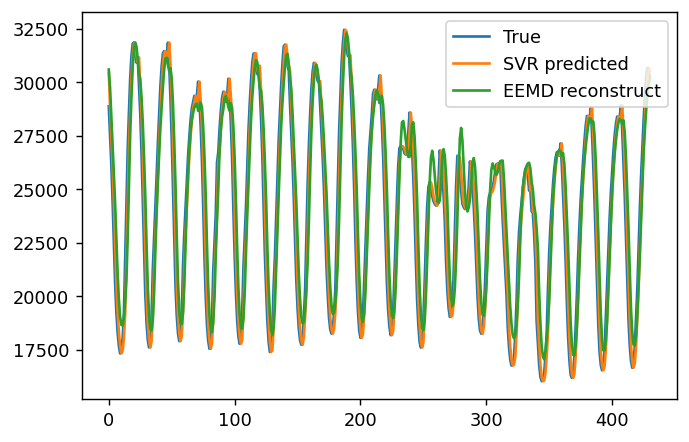

In [13]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
df = pd.read_excel('data/fourth_season.xlsx')
y_test_true = df['负荷数据'][-len(pred_test):]
rmse = mean_squared_error(y_test_true,y_pred_test)**0.5
mape = mean_absolute_percentage_error(y_test_true,y_pred_test)
svr_pred_test = pd.read_excel('data/svr_test_y_pred.xlsx')
print(f'EEMD分解时, 网格搜索后SVR预测RMSE = {round(rmse,3)}, MAPE = {round(mape,3)}')

plt.rcParams['figure.dpi'] = 128
plt.plot(range(len(y_test_true)),y_test_true,label = 'True')
plt.plot(range(len(y_test_true)),np.array(svr_pred_test)[:,1],label = 'SVR predicted')
plt.plot(range(len(y_test_true)),y_pred_test,label = 'EEMD reconstruct')
# plt.plot(range(len(y_test_true)),np.array(svr_pred_test)[:,1],label = 'SVR predicted')
plt.legend()

In [14]:
pd.DataFrame(y_pred_test).to_excel('./data/svr_GS_EEMD.xlsx',index=None)
pd.DataFrame(y_test_true).to_excel('./data/y_true.xlsx',index=None)